## Cataloging severe wind cases over Iowa for EARNEST

This notebooks generates quicklooks to enable choosing cases with severe wind damage for EARNEST training data. We load SPC wind reports over Iowa for a day and make a quicklook plot in order to determine if there was wind damage on the given day for a storm.

In [53]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import dask.bag as db

from metpy.plots import USCOUNTIES
from datetime import datetime, timedelta

%matplotlib inline

Load example day: August 10, 2020 derecho over Iowa. Get .csv file directly from SPC.

In [7]:
reports = pd.read_csv('https://www.spc.noaa.gov/climo/reports/200810_rpts_wind.csv')
reports

,Time,Speed,Location,County,State,Lat,Lon,Comments
0,1200,58,BLACK RIVER FALLS,JACKSON,WI,44.30,-90.85,(ARX)
1,1235,UNK,5 N BABCOCK,WOOD,WI,44.37,-90.11,LARGE TREE DOWN AT THE INTERSECTION OF HIGHWAY...
2,1248,UNK,5 SW NEW ROME,JUNEAU,WI,44.19,-89.96,LAW ENFORCEMENT REPORTED A TREE DOWN IN ARMENI...
3,1303,UNK,2 N FRIENDSHIP,ADAMS,WI,44.00,-89.83,LAW ENFORCEMENT REPORTED A TREE DOWN NEAR 13TH...
4,1306,UNK,PENDER,THURSTON,NE,42.12,-96.71,LARGE OLDER TREE BLOWN DOWN. (OAX)
...,...,...,...,...,...,...,...,...
905,510,61,10 SW PADUCAH,COTTLE,TX,33.89,-100.40,OBSERVED BY THE WEST TEXAS MESONET (LUB)
906,516,62,3 SE HOBART,KIOWA,OK,35.00,-99.05,(OUN)
907,520,61,4 SE HOBART,KIOWA,OK,34.99,-99.04,(OUN)
908,635,UNK,1 SSW CORDOVA,ROCK ISLAND,IL,41.67,-90.33,SEVERAL LARGE TREE LIMBS ARE DOWN (AROUND 10 I...


Filter to only reports over Iowa.

In [11]:
reports = reports.where(reports["State"] == "IA").dropna()
reports

,Time,Speed,Location,County,State,Lat,Lon,Comments
7,1316.0,UNK,1 N SIOUX CITY,WOODBURY,IA,42.52,-96.39,BRANCHES AND PART OF A TREE LAYING IN THE ROAD...
8,1320.0,58,2 SW SERGEANT BLUFF,WOODBURY,IA,42.38,-96.38,ASOS STATION KSUX SIOUX GATEWAY AIRPORT. (FSD)
10,1324.0,67,2 SW SERGEANT BLUFF,WOODBURY,IA,42.38,-96.38,DELAYED REPORT. ASOS STATION KSUX SIOUX GATEWA...
14,1340.0,58,1 SW MOVILLE,WOODBURY,IA,42.48,-96.08,MESONET STATION RSCI4 SIOUX CITY (I-29). (FSD)
19,1400.0,UNK,2 NW LOGAN,HARRISON,IA,41.66,-95.81,LARGE TREE SNAPPED OFF. APPEARS TO BE AT LEAST...
...,...,...,...,...,...,...,...,...
292,1900.0,74,CLINTON AIRPORT,CLINTON,IA,41.83,-90.33,(DVN)
293,1900.0,UNK,1 NNE CLINTON,CLINTON,IA,41.85,-90.23,NUMEROUS REPORTS OF TREES... LIMBS ANDPOWERLIN...
294,1900.0,130,2 NE CLINTON,CLINTON,IA,41.86,-90.21,DELAYED REPORT. 400 FOOT RADIO BROADCAST TOWER...
295,1902.0,70,PARK VIEW,SCOTT,IA,41.69,-90.54,60 TO 70 MPH WINDS ESTIMATED. TIME IS ALSO EST...


Plot the locations of all of the reports.

Text(0.5, 1.0, 'SPC wind damage reports over Iowa 08-10-2020')

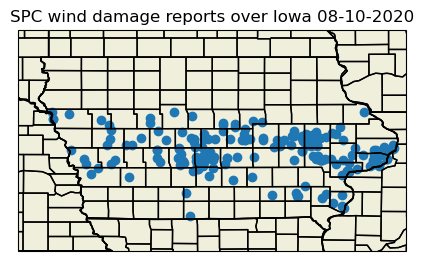

In [29]:
fig, ax = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(5,5))
ax.scatter(reports["Lon"], reports["Lat"])
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND)
ax.add_feature(USCOUNTIES)
ax.set_xlim([-97, -90])
ax.set_ylim([40, 44])
ax.set_title('SPC wind damage reports over Iowa 08-10-2020')

Generalize above code for a given day. Scale plotting code for a whole year over a LocalCluster.

In [65]:
def make_plot_for_day(day):
    try:
        reports = pd.read_csv(
           day.strftime('https://www.spc.noaa.gov/climo/reports/%y%m%d_rpts_wind.csv'))
    except:
        return
    reports = reports.where(reports["State"] == "IA").dropna()
    if len(reports["Lon"]) == 0:
        return
    fig, ax = plt.subplots(
        1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(5,5))
    ax.scatter(reports["Lon"], reports["Lat"], s=25, marker='d', color='b')
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(USCOUNTIES)
    ax.set_xlim([-97, -90])
    ax.set_ylim([40, 44])
    ax.set_title(day.strftime('SPC wind damage reports over Iowa %m-%d-%Y'))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    fig.tight_layout()
    fig.savefig('/lcrc/group/earthscience/rjackson/Earnest/wind_reports/wind_reports%s.png' % 
                day.strftime('%Y%m%d'), bbox_inches='tight', dpi=150)
    plt.close(fig)
    print(day.strftime('%Y%m%d') + " plotted!")

In [66]:
date_range = pd.date_range('2020-01-01', '2021-01-01')
bag = db.from_sequence(date_range)
results = bag.map(make_plot_for_day).compute()

20200801 plotted!
20201011 plotted!
20200609 plotted!
20200328 plotted!
20201110 plotted!
20200514 plotted!
20200523 plotted!
20200828 plotted!
20200905 plotted!
20200711 plotted!
20200714 plotted!
20200808 plotted!
20200810 plotted!
20200812 plotted!
20200525 plotted!
20200526 plotted!
20200602 plotted!
20200604 plotted!
20200618 plotted!
20200620 plotted!
20200621 plotted!
20200622 plotted!
20200625 plotted!
20200626 plotted!
20200627 plotted!
20200630 plotted!
20200707 plotted!
20200708 plotted!
20200709 plotted!
20200710 plotted!
